In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

#import skimage.io as io
from scipy.misc import bytescale

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Permute
from keras.layers import Convolution2D, Deconvolution2D, Cropping2D
from keras.layers import merge

Using TensorFlow backend.


In [3]:
from fcn_keras2 import fcn32_blank, fcn_32s_to_8s, prediction

In [4]:
from scipy.io import loadmat

In [5]:
# WARNING : weights from file pascal-fcn8s-dag.mat should reflect the same architecture
data = loadmat('pascal-fcn8s-tvg-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description

In [6]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i

In [7]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (1,0,2,3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    for i in range(0, p.shape[1]):
        matname = p[0,i].name[0][0:-1]
        matname_type = p[0,i].name[0][-1] # "f" for filter weights or "b" for bias
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print ('found : {0}, {1}, {2}'.format(matname, matname_type, kindex))
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            if  matname_type == 'f':
                l_weights = p[0,i].value
                f_l_weights = l_weights.transpose(prmt)
                f_l_weights = np.flip(f_l_weights, 2)
                f_l_weights = np.flip(f_l_weights, 3)
                assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
                current_b = kmodel.layers[kindex].get_weights()[1]
                kmodel.layers[kindex].set_weights([f_l_weights, current_b])
            elif  matname_type == 'b':
                l_bias = p[0,i].value
                assert (l_bias.shape[1] == 1)
                assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
                current_f = kmodel.layers[kindex].get_weights()[0]
                kmodel.layers[kindex].set_weights([current_f, l_bias[:,0]])
        else:
            print('not found : ' + str(matname))

In [8]:
image_size3 = 64*8
blank = fcn32_blank(image_size3)
fcn8model3 = fcn_32s_to_8s(blank)

imarr3 = np.ones((image_size3,image_size3, 3))
imarr3 = np.expand_dims(imarr3, axis=0)

shape = fcn8model3.predict(imarr3).shape
if (fcn8model3.predict(imarr3).shape != (1,image_size3,image_size3,21)):
    print('WARNING: size mismatch will impact some test cases')

copy_mat_to_keras(fcn8model3)

In [9]:
image_size1 = 64*4
fcn8model1 = fcn_32s_to_8s(fcn32_blank(image_size1))

imarr1 = np.ones((image_size1,image_size1,3))
imarr1 = np.expand_dims(imarr1, axis=0)

if (fcn8model1.predict(imarr1).shape != (1,21,image_size1,image_size1)):
    print('WARNING: size mismatch will impact some test cases')

copy_mat_to_keras(fcn8model1)

In [10]:
image_size2 = 64*6
fcn8model2 = fcn_32s_to_8s(fcn32_blank(image_size2))

imarr2 = np.ones((image_size2,image_size2,3))
imarr2 = np.expand_dims(imarr2, axis=0)

if (fcn8model2.predict(imarr2).shape != (1,21,image_size2,image_size2)):
    print('WARNING: size mismatch will impact some test cases')

copy_mat_to_keras(fcn8model2)

In [11]:
im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping

im1 = im.resize((image_size1,image_size1))
preds1 = prediction(fcn8model1, im1, transform=True)
imclass1 = np.argmax(preds1, axis=3)[0,:,:]

im2 = im.resize((image_size2,image_size2))
preds2 = prediction(fcn8model2, im2, transform=True)
imclass2 = np.argmax(preds2, axis=3)[0,:,:]

im3 = im.resize((image_size3,image_size3))
preds3 = prediction(fcn8model3, im3, transform=True)
imclass3 = np.argmax(preds3, axis=3)[0,:,:]


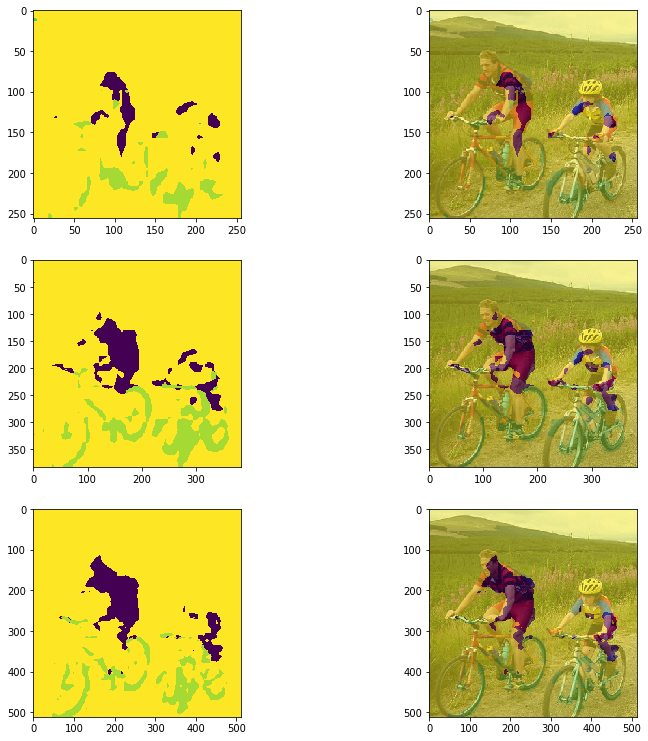

In [12]:
plt.figure(figsize = (13, 13))

plt.subplot(3,2,1)
plt.imshow( imclass1 )
plt.subplot(3,2,2)
plt.imshow( np.asarray(im1) )
masked_imclass1 = np.ma.masked_where(imclass1 == 0, imclass1)
plt.imshow( masked_imclass1, alpha=0.5 )

plt.subplot(3,2,3)
plt.imshow( imclass2 )
plt.subplot(3,2,4)
plt.imshow( np.asarray(im2) )
masked_imclass2 = np.ma.masked_where(imclass2 == 0, imclass2)
plt.imshow( masked_imclass2, alpha=0.5 )

plt.subplot(3,2,5)
plt.imshow( imclass3 )
plt.subplot(3,2,6)
plt.imshow( np.asarray(im3) )
masked_imclass3 = np.ma.masked_where(imclass3 == 0, imclass3)
plt.imshow( masked_imclass3, alpha=0.5 )